## First Step: generate non-uniform sampling (NUS)

 The library for compressed sensing, contains both the function to generate the NUS Poisson distribution and the function to perform the compressed sensing algorithm

function: cs.GenPoissonDist()
Input: 
- total_number_of_indices
- number_of_subsamples
Output:
- indices_subset of indices

In [1]:
import numpy as np
#
import compressed_sensing as cs 

#TODO:add spectrometer frequency? Not sure if useful

total_number_of_indices = 2000 #number of samples for the full correlators
max_time = np.pi*100 #maximum time for the full correlators
print('The correlators are sampled from 0 to Max t:',max_time)

full_time_range = np.linspace(0, max_time, total_number_of_indices)
percentage =0.25 #from 0 to 1

number_of_subsamples = round(total_number_of_indices*percentage) # number of subsample of full_time_range
print('Number of sub-samples to get from the full_correlators:',percentage*100,'% ,', number_of_subsamples,' out of ',total_number_of_indices)

indices_subset = cs.GenPoissonDist(number_of_subsamples,total_number_of_indices, usenumpy=True)
print('Subset of points (NUS sampling):'+str(len(indices_subset))+' points\n',indices_subset)

The correlators are sampled from 0 to Max t: 314.1592653589793
Number of sub-samples to get from the full_correlators: 25.0 % , 500  out of  2000
Subset of points (NUS sampling):500 points
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24, 26, 28, 29, 30, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 52, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 74, 75, 76, 77, 79, 81, 82, 83, 84, 85, 88, 90, 92, 93, 94, 95, 96, 98, 99, 100, 101, 103, 105, 107, 109, 110, 111, 113, 114, 115, 116, 118, 119, 120, 121, 123, 124, 125, 127, 129, 132, 135, 136, 139, 140, 142, 145, 147, 149, 150, 151, 152, 153, 154, 156, 158, 160, 163, 164, 165, 167, 168, 170, 171, 173, 174, 176, 177, 180, 182, 184, 185, 187, 189, 191, 192, 196, 198, 201, 203, 206, 207, 210, 211, 214, 217, 218, 220, 221, 226, 227, 228, 230, 234, 235, 238, 241, 244, 247, 249, 250, 252, 253, 256, 258, 260, 261, 263, 266, 269, 271, 272, 274, 276, 280, 281, 284, 286, 288,

In [2]:
#decide to compute sub correlators separately or get it from the full correlators. 
#In real usecase we would have True; we would not generate the full correlators, but here is just used to compare the results of the compressed sensing algorithm
compute_sub_correlators_separately = False

# Step2: generate spin-sub_correlators signal (also full signal)

In [3]:
from spin_correlator_app import correlation_function, NMRCorrelationSimulator
from struqture_py import spins

# Set up the spin system, and define the spin-correlator function
#
number_qubits = 2
gyromagnetic = 1.0
coupling = 1.0
shift = 1.0
#
gyromagnetic_factors = [gyromagnetic for _ in range(number_qubits)]

hamiltonian = spins.SpinHamiltonianSystem()
for i in range(number_qubits):
    hamiltonian.add_operator_product(spins.PauliProduct().z(i), -shift * i)
for i in range(number_qubits - 1):
    hamiltonian.add_operator_product(spins.PauliProduct().x(i).x(i + 1), coupling)
    hamiltonian.add_operator_product(spins.PauliProduct().y(i).y(i + 1), coupling)



full_correlators = correlation_function(hamiltonian, gyromagnetic_factors, full_time_range, number_trottersteps = 10, dephasing = 0.001)

if compute_sub_correlators_separately:
    sub_time_range = full_time_range[indices_subset]
    sub_correlators = correlation_function(hamiltonian, gyromagnetic_factors, sub_time_range, number_trottersteps = 10, dephasing = 0.001)
else:
    
    sub_correlators = {'spin_total' : [full_correlators['spin_total'][index] for  index in indices_subset]}


Copyright © 2021-2022 HQS Quantum Simulations GmbH. All Rights Reserved.
Struqture python interface
Copyright © 2021-2022 HQS Quantum Simulations GmbH. All Rights Reserved.

 Licensed under conditions specified in LICENSE file for source distribution and LICENSE_FOR_BINRARY_DISTRIBUTION for binary distribution.


Plot full signal vs sub-sampling

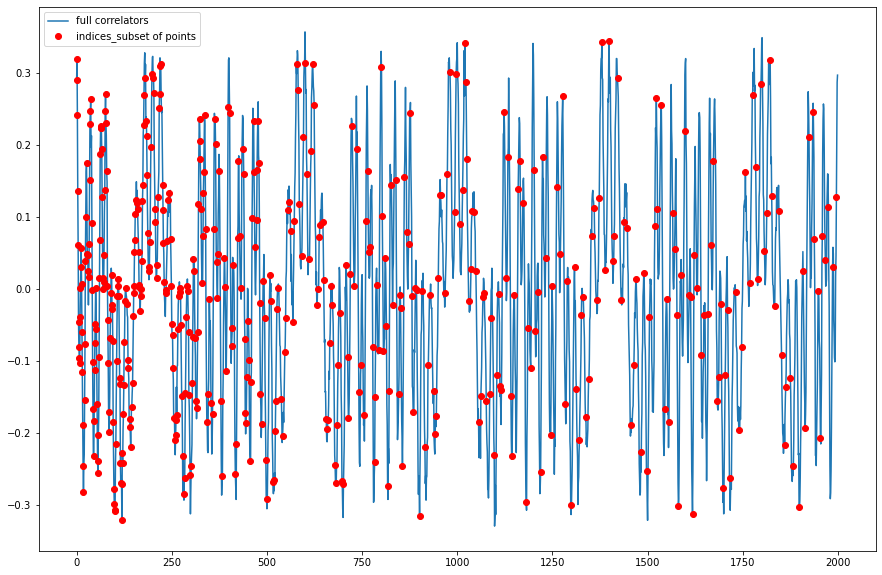

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,10))
plt.plot(full_correlators['spin_total'], label='full correlators')
plt.plot(indices_subset,sub_correlators['spin_total'],linestyle='none', marker='o', color='red', label='indices_subset of points')
plt.legend()

## STEP 3: Compressed sensing (CS) reconstruction
Reconstruct signal from sub-sampling. Use inverse Fourier transform matrix to reconstruct signal, minimizing L1 norm.

Using function cs.CS_Recontruction()
Input:
- correaltor of the sub-sampling
- indices_subset of points (to get a submatrix from the original IDCT matrix)
- total_number_of_indices (to create the IDCT matrix)

In [8]:
import scipy.fftpack as spfft
# reconstruct the full signal using the inverse DCT
full_signal = spfft.dct(full_correlators['spin_total'], norm='ortho') # DCT of the signal, Discrete Cosine Transform ,Fourier Transform

print('\n\nSubset:(',percentage*100,'% of the full signal)','(',len(indices_subset),'samples)')

# reconstruct signal from indices_subset of points
signal_reconstruced, result_info = cs.CS_Reconstruction(sub_correlators['spin_total'],indices_subset,total_number_of_indices)



Subset:( 25.0 % of the full signal) ( 500 samples)
                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Sep 01 05:41:07 PM: Your problem has 2000 variables, 1 constraints, and 0 parameters.
(CVXPY) Sep 01 05:41:07 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 01 05:41:07 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 01 05:41:07 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 01 05:41:07 PM: Compiling problem (target solver=ECOS).
(CVXPY) Sep 01 05:41:07 PM: Reduction cha

/home/gsilvi/miniforge3/envs/MERCK/lib/python3.9/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


(CVXPY) Sep 01 05:41:08 PM: Applying reduction ECOS
(CVXPY) Sep 01 05:41:08 PM: Finished problem compilation (took 8.429e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Sep 01 05:41:08 PM: Invoking solver ECOS  to obtain a solution.

ECOS 2.0.10 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -2.306e-23  -0.000e+00  +3e+03  1e+00  1e-02  1e+00  9e-01    ---    ---    1  1  - |  -  - 
 1  +1.246e+01  +1.246e+01  +6e+02  8e-01  2e-03  2e-01  2e-01  0.8377  2e-02   1  1  1 |  0  0
 2  +2.816e+01  +2.816e+01  +4e+02  5e-01  1e-03  1e-01  9e-02  0.5282  2e-01   1  1  0 |  0  0
 3  +3.240e+01  +3.240e+01  +2e+02  2e-01  6e-04  5e-02  4e-02  0.6511  2e-01 

Plot full signal vs reconstructed signal

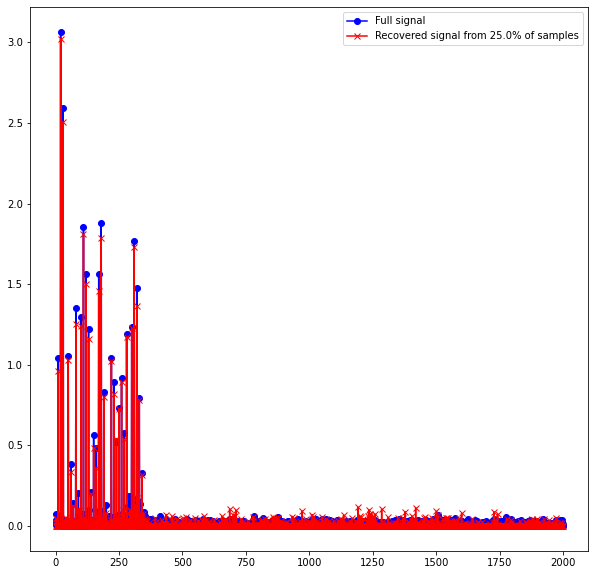

In [9]:
plt.figure(figsize=(10,10))
plt.plot(np.abs(full_signal),marker='o',color='blue',label='Full signal')
plt.plot(np.abs(signal_reconstruced.value),marker='x',color='red', label='Recovered signal from '+ str(percentage*100)+'% of samples')
plt.legend()
